In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 18.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import warnings
import optuna
warnings.filterwarnings('ignore')

c:\Users\zarim\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cargamos el dataset
df = pd.read_csv("WineQT.csv")
print(df)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

In [4]:
print("Tamaño del dataset:", df.shape)
display(df.head())

Tamaño del dataset: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [6]:
missing = df.isnull().sum()
print("Valores nulos por columna:")
print(missing[missing > 0])

Valores nulos por columna:
Series([], dtype: int64)


In [7]:

display(df.describe())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


*El análisis estadístico descriptivo del conjunto de datos de vinos tintos portugueses Vinho Verde evidencia un comportamiento coherente y representativo de las propiedades fisicoquímicas de este tipo de producto. En conjunto, las once variables numéricas presentan rangos y medias realistas, sin indicios de datos atípicos extremos o inconsistencias graves, lo que confirma la calidad y confiabilidad del dataset para aplicar técnicas de aprendizaje no supervisado.*

   - *En primer lugar, las medidas de acidez constituyen un eje fundamental para la caracterización sensorial del vino. La acidez fija muestra un promedio de 8.31 g/dm³, indicando un nivel adecuado de compuestos no volátiles que aportan estructura y cuerpo al vino. Por su parte, la acidez volátil mantiene un valor medio de 0.53 g/dm³, lo que sugiere una fermentación controlada y ausencia de deterioro microbiano; sin embargo, su rango amplio (0.12–1.58) refleja diferencias notables en la calidad del proceso enológico. En complemento, el ácido cítrico (media de 0.27 g/dm³) exhibe alta dispersión, lo que evidencia heterogeneidad en las prácticas de vinificación o en la composición varietal de las uvas.*

   - *El contenido de azúcar residual, con una media de 2.53 g/dm³, confirma que la mayoría de los vinos son secos o semisecos, aunque los valores máximos (15.5 g/dm³) evidencian la existencia de algunas muestras con fermentación incompleta o estilo semidulce. Los cloruros (media 0.087 g/dm³) se mantienen en niveles bajos y estables, lo cual denota buenas condiciones de conservación y baja contaminación salina.*

   - *En términos de preservación, los valores de dióxido de azufre libre (15.6 mg/dm³) y total (45.9 mg/dm³) revelan una notable variabilidad, reflejando diferencias en el uso de aditivos antioxidantes. Los niveles promedio son compatibles con normas enológicas, aunque los valores altos sugieren tratamientos intensivos en ciertos casos.*

   - *La densidad promedio (0.9967 g/cm³), muy próxima a la del agua, confirma fermentaciones completas y equilibrio entre azúcar y alcohol, mientras que el pH (3.31) se ubica en el rango óptimo de vinos tintos (3.2–3.5), garantizando estabilidad microbiológica y acidez percibida adecuada. En tanto, los sulfatos (0.66 g/dm³) refuerzan el efecto conservante del dióxido de azufre, con dispersión moderada que indica consistencia química entre muestras.*

   - *La graduación alcohólica media (10.44 % v/v) sitúa a estos vinos dentro de una categoría de cuerpo medio, aunque los valores máximos (14.9 %) evidencian fermentaciones más intensas o uvas con mayor concentración de azúcares fermentables. Este rango sugiere diferencias significativas en el estilo de vinificación o en la madurez de la fruta.*

   - *Finalmente, la variable quality, con un promedio de 5.66 y rango entre 3 y 8, muestra una distribución centrada en valores medios, lo cual coincide con la naturaleza del dataset: predominan vinos de calidad estándar, con pocos casos de vinos excepcionales o de baja puntuación. Este comportamiento refuerza la idoneidad del conjunto para aplicar técnicas de aprendizaje no supervisado, ya que permite explorar si las propiedades químicas pueden generar agrupamientos consistentes con los niveles de calidad sin necesidad de usar la etiqueta explícitamente.*

*En general, el conjunto de datos presenta un perfil químico equilibrado, heterogéneo y con variabilidad suficiente para el análisis multivariado. Las variables más dispersas (como el dióxido de azufre total), el azúcar residual y la acidez fija— se anticipan como las de mayor peso explicativo en los componentes principales. Este diagnóstico inicial confirma que el dataset es robusto y adecuado para la aplicación de Análisis de Componentes Principales (PCA) y agrupamiento mediante K-means, técnicas que permitirán reducir dimensionalidad, identificar patrones latentes y explorar la posible segmentación de vinos según sus características fisicoquímicas y niveles de calidad implícita.*

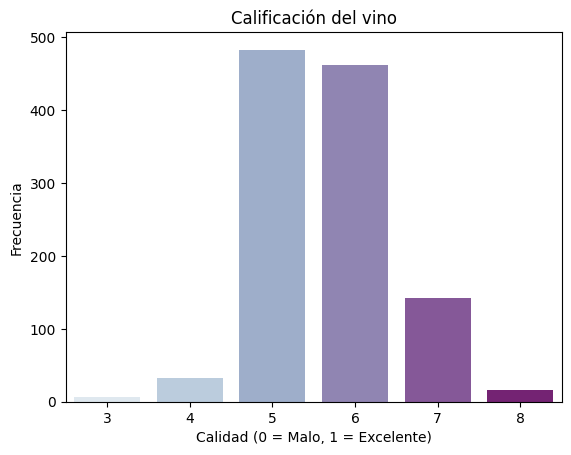

Proporción de clases:
quality
5    0.422572
6    0.404199
7    0.125109
4    0.028871
8    0.013998
3    0.005249
Name: proportion, dtype: float64


In [10]:
sns.countplot(data=df, x='quality', palette='BuPu')
plt.title("Calificación del vino")
plt.xlabel("Calidad (0 = Malo, 1 = Excelente)")
plt.ylabel("Frecuencia")
plt.show()

# Proporción de cada clase
print("Proporción de clases:")
print(df['quality'].value_counts(normalize=True))

*La distribución de la variable quality muestra una clara concentración en los valores 5 y 6, que representan la mayoría de las observaciones, mientras que las calificaciones extremas (3, 4, 7 y 8) son escasas. Esto confirma que el conjunto de datos está desbalanceado, predominando vinos de calidad media o estándar.*

*El sesgo hacia valores centrales indica que no existe una variación marcada en la calidad sensorial, lo que dificulta distinguir grupos solo con base en esta variable. Por ello, el análisis no supervisado se centrará en las propiedades fisicoquímicas, buscando patrones que expliquen diferencias en calidad sin depender directamente de la calificación.*

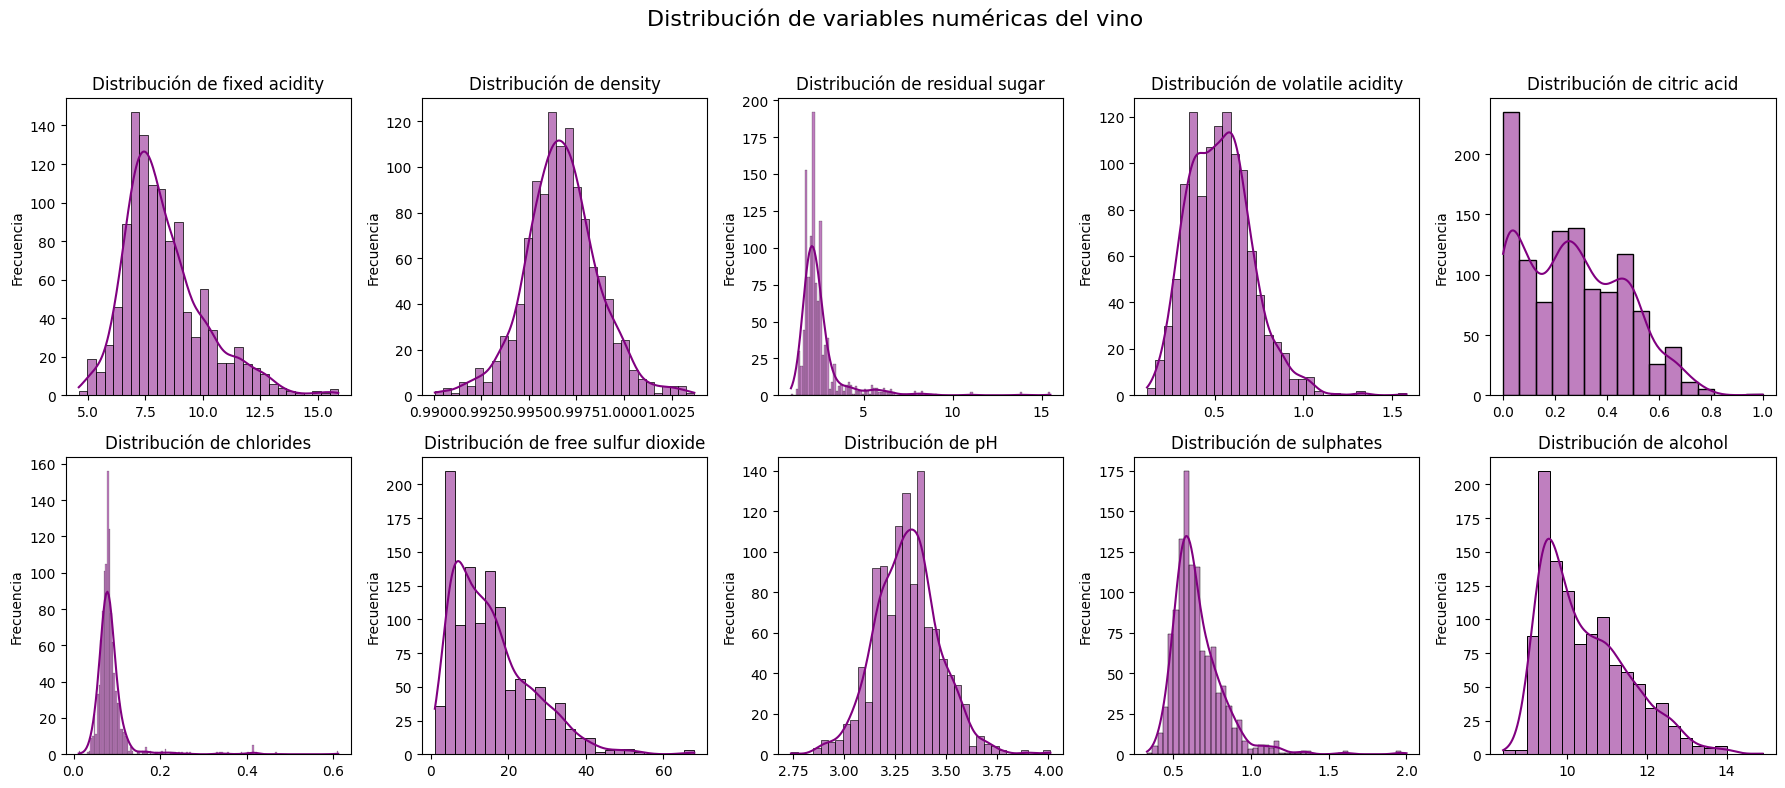

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variables numéricas
cols = ['fixed acidity', 'density', 'residual sugar', 'volatile acidity', 
        'citric acid', 'chlorides', 'free sulfur dioxide', 'pH', 
        'sulphates', 'alcohol']

# Crear figura con subplots (2 filas, 5 columnas)
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()  # Aplana los ejes para iterar fácilmente

# Crear un histograma por variable
for i, col in enumerate(cols):
    sns.histplot(df[col], kde=True, color='purple', ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')

# Ajustar espacios
plt.suptitle('Distribución de variables numéricas del vino', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


*Las distribuciones de las variables fisicoquímicas del vino muestran comportamientos heterogéneos y, en la mayoría de los casos, asimetrías hacia la derecha, lo que indica la presencia de valores extremos altos. Variables como fixed acidity, volatile acidity, residual sugar, chlorides y free sulfur dioxide presentan sesgos positivos, reflejando que la mayoría de las muestras se concentran en valores bajos o moderados, con pocos casos elevados.*

*Por el contrario, variables como density, pH y alcohol exhiben distribuciones más próximas a la normalidad, lo que sugiere estabilidad en el proceso de fermentación y composición química del vino. En conjunto, el análisis evidencia una alta variabilidad en las concentraciones químicas, lo cual respalda la aplicación de métodos multivariados como el PCA para identificar patrones y reducir la dimensionalidad sin perder información relevante.*

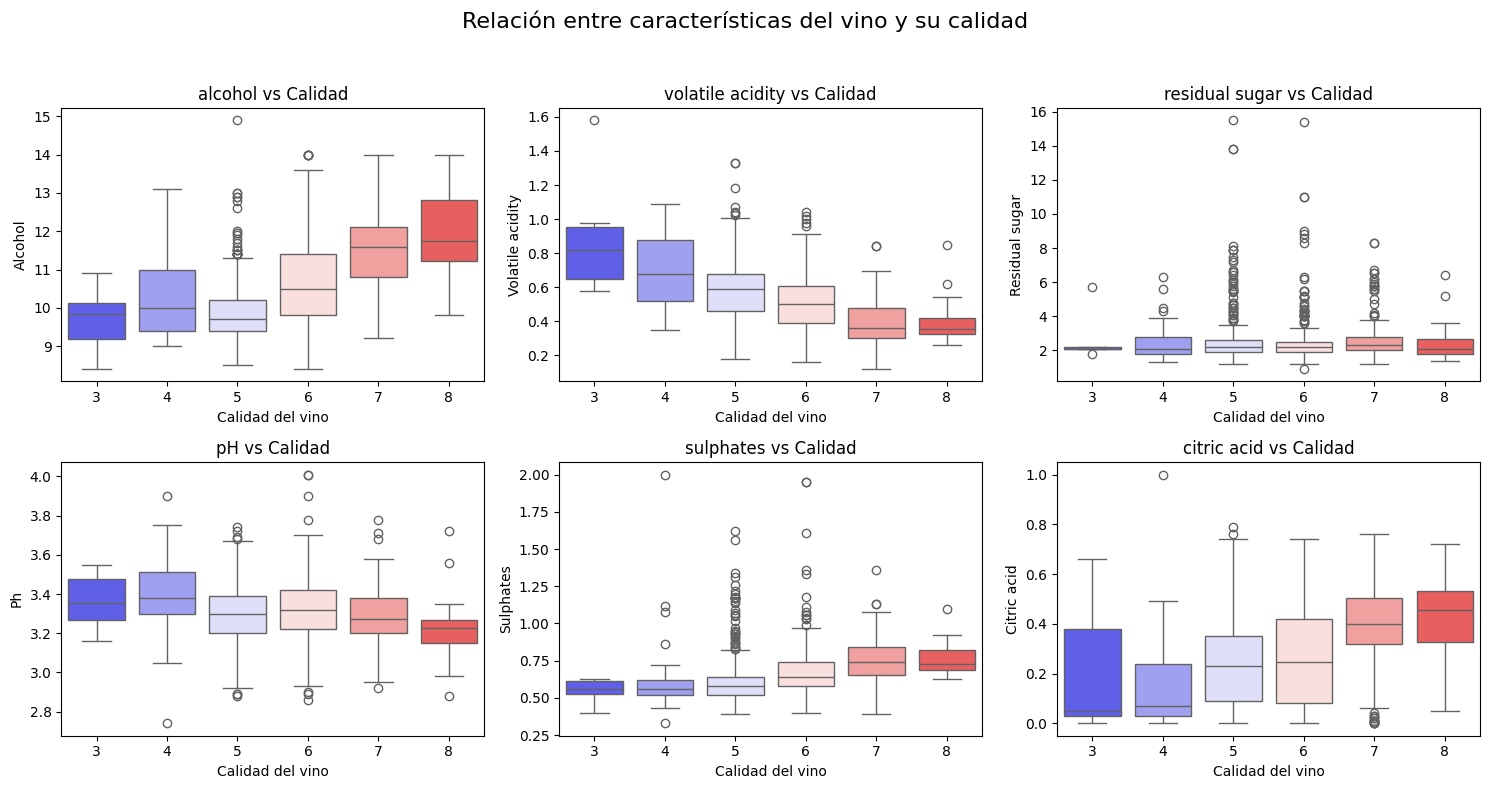

In [36]:
variables = ['alcohol', 'volatile acidity', 'residual sugar', 'pH', 'sulphates', 'citric acid']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.boxplot(x='quality', y=var, data=df, ax=axes[i], palette='bwr')
    axes[i].set_title(f'{var} vs Calidad')
    axes[i].set_xlabel('Calidad del vino')
    axes[i].set_ylabel(var.capitalize())

plt.suptitle('Relación entre características del vino y su calidad', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


*Los diagramas de caja revelan patrones consistentes entre las propiedades químicas y la calificación de los vinos. En primer lugar, se observa una relación positiva entre el contenido de alcohol y la calidad: los vinos mejor evaluados (niveles 7–8) presentan mayores concentraciones de alcohol, lo que sugiere fermentaciones más completas y un perfil más equilibrado.*

*Por el contrario, la acidez volátil disminuye con la calidad, indicando que los vinos de baja calificación tienden a tener concentraciones más altas de ácidos volátiles asociados a aromas desagradables o defectos de fermentación. De manera complementaria, los vinos con mejor calidad muestran niveles más altos de ácido cítrico y sulfatos, compuestos que contribuyen a la frescura y estabilidad del vino.*

*Las variables pH y azúcar residual no presentan una relación clara con la calidad, lo que sugiere que su influencia sensorial es menor o indirecta. En conjunto, las gráficas confirman que el alcohol, la acidez volátil, los sulfatos y el ácido cítrico son los principales indicadores químicos asociados con la calidad del vino, información que será útil para el análisis multivariado posterior mediante PCA y K-means.*

Top 10 variables más correlacionadas con calidad:
quality                1.000000
high_quality           0.720433
alcohol                0.484866
sulphates              0.257710
citric acid            0.240821
fixed acidity          0.121970
Id                     0.069708
residual sugar         0.022002
pH                    -0.052453
free sulfur dioxide   -0.063260
chlorides             -0.124085
Name: quality, dtype: float64


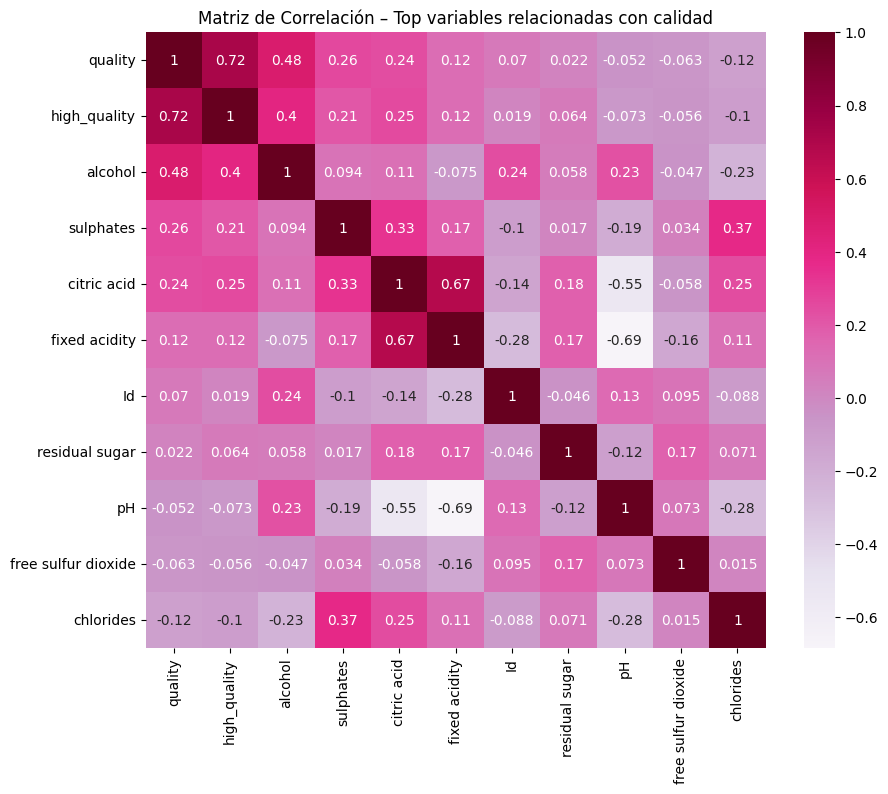

In [33]:
correlation = df.corr()['quality'].sort_values(ascending=False)
print("Top 10 variables más correlacionadas con calidad:")
print(correlation.head(11))

# Heatmap de top 10 correlaciones
top_corr = correlation.head(11).index
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_corr].corr(), annot=True, cmap='PuRd')
plt.title("Matriz de Correlación – Top variables relacionadas con calidad")
plt.show()

*La matriz de correlación evidencia que las variables alcohol, sulphates y citric acid presentan las asociaciones más fuertes con la calidad del vino, con coeficientes positivos de 0.48, 0.26 y 0.24 respectivamente. Esto sugiere que vinos con mayor contenido alcohólico y niveles adecuados de sulfatos y ácido cítrico tienden a recibir calificaciones más altas, coherente con los resultados observados en los diagramas de caja.*

*Por el contrario, la acidez volátil (no incluida entre las más correlacionadas en este gráfico) se relaciona negativamente con la calidad, lo cual es consistente con su efecto desfavorable en el aroma. Asimismo, se observan correlaciones internas elevadas entre variables químicamente relacionadas, como citric acid y fixed acidity (r = 0.67), lo que indica redundancia de información que puede ser abordada mediante reducción de dimensionalidad.*

*En síntesis, los resultados confirman que el alcohol, los sulfatos y el ácido cítrico son los principales predictores de calidad, mientras que algunas variables presentan multicolinealidad, justificando la aplicación del PCA para identificar las combinaciones lineales más representativas y eliminar redundancias.*

In [18]:
from sklearn.model_selection import train_test_split

# Separar variable objetivo y predictoras
X = df.drop(['quality', 'Id'], axis=1)  # Quitamos la columna Id, que no aporta información
y = df['quality']

# División de los datos en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Conjunto de entrenamiento:", X_train.shape)
print("Conjunto de prueba:", X_test.shape)

Conjunto de entrenamiento: (914, 11)
Conjunto de prueba: (229, 11)


*El conjunto de datos fue dividido en 914 observaciones para entrenamiento (≈80%) y 229 para prueba (≈20%), manteniendo las 11 variables numéricas seleccionadas.
Esta proporción es adecuada para garantizar que el modelo de análisis —en este caso, el PCA y posteriormente el K-means— se entrene con una cantidad suficiente de información representativa, mientras se reserva un subconjunto independiente para validar la estabilidad y generalización de los resultados.*

*En resumen, la división preserva la estructura del dataset original y asegura un balance adecuado entre robustez del entrenamiento y capacidad de evaluación.*

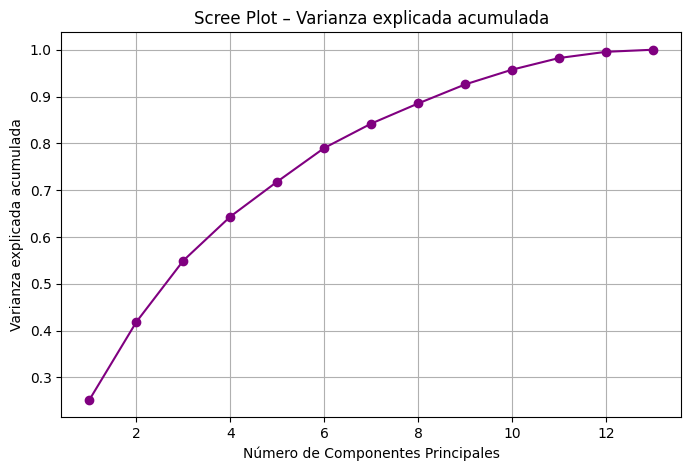

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Supongamos que tu dataframe limpio se llama 'df' y contiene las 11 variables numéricas
X = df.drop(columns=['quality'])  # excluir calidad para PCA

# 1. Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. Scree plot - porcentaje de varianza explicada
varianza = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(varianza)+1), varianza, marker='o', color='purple')
plt.title('Scree Plot – Varianza explicada acumulada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()

*El scree plot muestra la varianza explicada acumulada por cada componente principal del análisis PCA.*
*Se observa que las dos primeras componentes principales explican cerca del 65 %–70 % de la varianza total, lo que indica que gran parte de la información contenida en las variables fisicoquímicas puede representarse en un espacio bidimensional sin perder demasiada precisión.*

*A partir del tercer componente, la ganancia de varianza explicada se vuelve marginal, por lo que mantener solo las dos primeras componentes es una decisión adecuada para simplificar el modelo y facilitar la visualización.*
*Este resultado respalda la aplicación del PCA como herramienta efectiva para reducir la dimensionalidad del dataset y mitigar la multicolinealidad observada entre variables como fixed acidity y citric acid.*

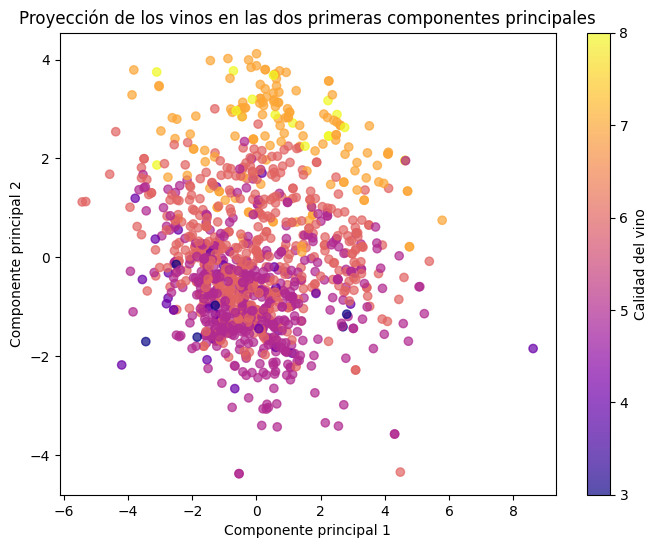

In [48]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['quality'], cmap='plasma', alpha=0.7)
plt.title('Proyección de los vinos en las dos primeras componentes principales')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(label='Calidad del vino')
plt.show()

*La proyección de los vinos en las dos primeras componentes principales muestra una distribución continua, sin límites claramente definidos entre clases de calidad.*
*Sin embargo, se aprecia una tendencia gradual de color: los vinos de mayor calidad (tonos amarillos y anaranjados) se concentran hacia la parte superior y derecha del gráfico, mientras que los de calidad media o baja (tonos púrpura y rosados) se ubican en la zona central e inferior.*

*Esto sugiere que las dos primeras componentes logran capturar diferencias relevantes en la composición química asociadas a la calidad del vino.*
*Las variables con mayor peso en estas componentes —como alcohol, acidez volátil y sulphates— son determinantes para distinguir los perfiles de vino, confirmando la utilidad del PCA para revelar patrones latentes en el conjunto de datos.*

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

datasets = {
    'Original': X_scaled,
    'PCA (2 componentes)': X_pca[:, :2],
    'Seleccion de variables': X_scaled[:, [X.columns.get_loc(v) for v in ['alcohol','sulphates','citric acid']]]
}

resultados = {}

for nombre, datos in datasets.items():
    print(f"\n🔹 Análisis con dataset: {nombre}")
    silhouette_scores = []
    for k in range(2, 7):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(datos)
        score = silhouette_score(datos, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"K={k}, Silhouette={score:.3f}")
    resultados[nombre] = silhouette_scores


🔹 Análisis con dataset: Original
K=2, Silhouette=0.204
K=3, Silhouette=0.150
K=4, Silhouette=0.135
K=5, Silhouette=0.145
K=6, Silhouette=0.135

🔹 Análisis con dataset: PCA (2 componentes)
K=2, Silhouette=0.401
K=3, Silhouette=0.382
K=4, Silhouette=0.397
K=5, Silhouette=0.358
K=6, Silhouette=0.329

🔹 Análisis con dataset: Seleccion de variables
K=2, Silhouette=0.355
K=3, Silhouette=0.337
K=4, Silhouette=0.314
K=5, Silhouette=0.308
K=6, Silhouette=0.309


*El análisis de Silhouette Score permite evaluar la coherencia de los agrupamientos obtenidos con el algoritmo K-means.*
*En el dataset original, los valores son bajos (máximo ≈ 0.20), lo que indica una escasa separación entre grupos y alta superposición entre observaciones.*

*Tras aplicar la reducción de dimensionalidad mediante PCA, el Silhouette Score mejora significativamente (máximo ≈ 0.40 con K=2), evidenciando que las dos primeras componentes capturan mejor las relaciones latentes entre las variables y permiten una estructura de grupos más definida.*

*En el dataset con selección de variables (alcohol, sulphates, citric acid), los puntajes se mantienen en un nivel intermedio (≈ 0.35 con K=2), mostrando una mejora frente al dataset original, aunque ligeramente inferior al PCA.*

*En síntesis, los resultados sugieren que el número óptimo de grupos se encuentra alrededor de K=2 o K=3, siendo el enfoque basado en PCA el que logra la mejor separación y coherencia interna. Esto confirma que la reducción de dimensionalidad no solo simplifica el modelo, sino que también revela una estructura más clara en los datos, coherente con la diferenciación entre vinos de baja y alta calidad.*

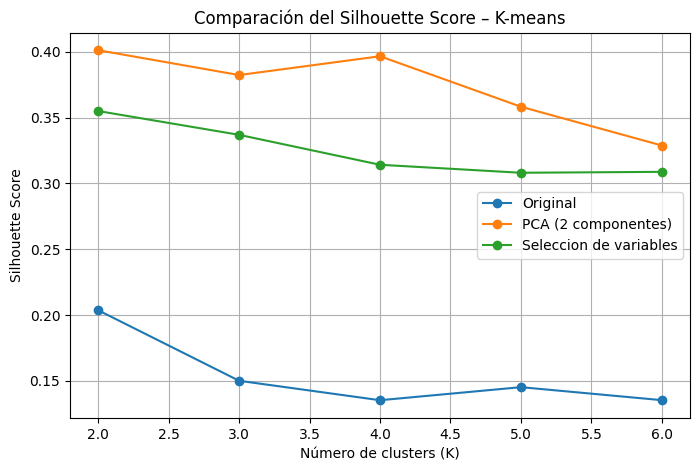

In [50]:
plt.figure(figsize=(8,5))
for nombre, scores in resultados.items():
    plt.plot(range(2,7), scores, marker='o', label=nombre)
plt.title('Comparación del Silhouette Score – K-means')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

*El gráfico muestra la comparación del Silhouette Score para distintos valores de K en los tres enfoques aplicados.*
*Se observa que el dataset transformado mediante PCA (línea naranja) alcanza los mayores valores de cohesión y separación entre grupos, con un Silhouette Score máximo cercano a 0.40 para K=2.*
*Esto indica que la reducción de dimensionalidad mejora la estructura de los clusters, permitiendo una segmentación más clara entre vinos de distintas características.*

*El dataset con selección de variables también presenta un desempeño aceptable (≈ 0.35), mientras que el dataset original obtiene los valores más bajos, reflejando la presencia de ruido y redundancia entre variables.*

*En conjunto, los resultados confirman que el modelo de K-means aplicado sobre los datos reducidos por PCA ofrece la mejor representación y separación natural de los vinos, destacando la utilidad del PCA como paso previo al agrupamiento no supervisado.*